# Summary

Exploring developer velocity as a way of understanding project health on github.

In [5]:
from collections import defaultdict
import os
from urllib.parse import urljoin

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from okra.playbooks import local_persistance
from okra.models import (Meta, Author, Contrib, CommitFile, Info)
from okra.models import DataAccessLayer

In [6]:
DATA = "/Users/tylerbrown/code/"
repos = [
    "torvalds/linux",
    "docker/docker-ce",
    'apache/attic-lucy',
    'apache/attic-wink',
    'apache/spark',
    'apache/lucene-solr'
]

for repo_name in repos:
    local_persistance(repo_name, DATA)

Issue with row 0, repo '/Users/tylerbrown/code/torvalds/linux'
Issue with row 0, repo '/Users/tylerbrown/code/docker/docker-ce'
Issue with row 0, repo '/Users/tylerbrown/code/apache/attic-lucy'
Issue with row 0, repo '/Users/tylerbrown/code/apache/attic-wink'
Issue with row 0, repo '/Users/tylerbrown/code/apache/spark'
Issue with row 0, repo '/Users/tylerbrown/code/apache/lucene-solr'


In [61]:
def date_transform(datedict):
    these = {}
    for key in datedict.keys():
        item = datedict[key]
        new_key = str(item.year) + '-' + str(item.dayofyear)
        these[new_key] = item
    return these

def author_transform(autdict):
    items = defaultdict(list)
    for idx in range(len(autdict['commit_hash'])):
        
        new_key = str(autdict['date_authored'][idx].year) + '-' + str(autdict['date_authored'][idx].dayofyear)
        new_item = (autdict['author_email'][idx], autdict['author_name'][idx], 
                    autdict['commit_hash'][idx], autdict['date_authored'][idx], 
                    autdict['lines_added'][idx], autdict['lines_deleted'][idx])
        items[new_key].append(new_item)
        
    return items

def date_join(autht, datet):
    
    rows = []
    r = {
        'date_key': np.NaN,
        'author_email': np.NaN,
        'author_name': np.NaN,
        'commit_hash': np.NaN,
        'date_authored': np.NaN,
        'lines_added': np.NaN,
        'lines_deleted': np.NaN,
    }

    for date_key in datet.keys():
        
        if date_key in autht:
            
            for i in autht[date_key]:
                
                rd = r.copy()
                rd['date_key'] = date_key
                rd['author_email'] = i[0]
                rd['author_name'] = i[1]
                rd['commit_hash'] = i[2]
                rd['date_authored'] = i[3]
                rd['lines_added'] = i[4]
                rd['lines_deleted'] = i[5]
                
                rows.append(rd)
    return rows

In [62]:
repodbs = {i : i.replace("/", "__REPODB__") + ".db" for i in repos}
repodbs

{'torvalds/linux': 'torvalds__REPODB__linux.db',
 'docker/docker-ce': 'docker__REPODB__docker-ce.db',
 'apache/attic-lucy': 'apache__REPODB__attic-lucy.db',
 'apache/attic-wink': 'apache__REPODB__attic-wink.db',
 'apache/spark': 'apache__REPODB__spark.db',
 'apache/lucene-solr': 'apache__REPODB__lucene-solr.db'}

In [43]:
conn_string = "sqlite:///" + urljoin(DATA, repodbs['torvalds/linux'])

In [44]:
dal = DataAccessLayer(conn_string)
dal.connect()
dal.session = dal.Session()

In [45]:
# let's do this by author per file now

q5 = dal.session.query(
    Meta.commit_hash, Author.authored, Author.name, Author.email,
    CommitFile.lines_added, CommitFile.lines_deleted
).join(Author).join(CommitFile)

items = []
for item in q5.all():
    r = {
        "commit_hash": item.commit_hash,
        "date_authored": item.authored,
        "author_name": item.name,
        "author_email": item.email,
        "lines_added": item.lines_added,
        "lines_deleted": item.lines_deleted,
    }
    items.append(r)
autdf = pd.DataFrame(items)
print(autdf.shape)

(1824726, 6)


In [63]:
per = autdf.date_authored.dt.to_period('D')

In [64]:
autdf['date_authored'] = autdf.date_authored.apply(lambda x: pd.Timestamp(x))

In [164]:
dates = pd.DataFrame(pd.date_range('2005-01', '2019-01', freq='D'))
dates.columns = ['dates']
dates.head()

,dates
0,2005-01-01
1,2005-01-02
2,2005-01-03
3,2005-01-04
4,2005-01-05


In [66]:
datet = dates.to_dict()['dates']

In [67]:
autht = autdf.to_dict()

In [68]:
datedt = date_transform(datet)

In [69]:
authdt = author_transform(autht)

In [77]:
df = date_join(authdt, datedt)

In [82]:
df = pd.DataFrame(df)
df.shape

(1800811, 7)

In [83]:
df.head()

,author_email,author_name,commit_hash,date_authored,date_key,lines_added,lines_deleted
0,jdub@us.ibm.com,Josh Boyer,14f8351a313f364afbc565f1ddcd43f8cfdccf52,2005-01-06 21:16:45,2005-6,18,5
1,aia21@cantab.net,Anton Altaparmakov,149f0c5200188a43f1fc11ca2fb14d8183013d10,2005-01-12 13:52:30,2005-12,21,10
2,aia21@cantab.net,Anton Altaparmakov,07a4e2da7dd3c9345f84b2552872f9d38c257451,2005-01-12 13:08:26,2005-12,2,0
3,aia21@cantab.net,Anton Altaparmakov,07a4e2da7dd3c9345f84b2552872f9d38c257451,2005-01-12 13:08:26,2005-12,41,15
4,aia21@cantab.net,Anton Altaparmakov,07a4e2da7dd3c9345f84b2552872f9d38c257451,2005-01-12 13:08:26,2005-12,113,44


# Computing developer velocity

$$
v = \frac{d}{t}
$$

In [84]:
df['total_lines'] = df.lines_added + df.lines_deleted

In [130]:
df.head()

,author_email,author_name,commit_hash,date_authored,date_key,lines_added,lines_deleted,total_lines
0,jdub@us.ibm.com,Josh Boyer,14f8351a313f364afbc565f1ddcd43f8cfdccf52,2005-01-06 21:16:45,2005-6,18,5,23
1,aia21@cantab.net,Anton Altaparmakov,149f0c5200188a43f1fc11ca2fb14d8183013d10,2005-01-12 13:52:30,2005-12,21,10,31
2,aia21@cantab.net,Anton Altaparmakov,07a4e2da7dd3c9345f84b2552872f9d38c257451,2005-01-12 13:08:26,2005-12,2,0,2
3,aia21@cantab.net,Anton Altaparmakov,07a4e2da7dd3c9345f84b2552872f9d38c257451,2005-01-12 13:08:26,2005-12,41,15,56
4,aia21@cantab.net,Anton Altaparmakov,07a4e2da7dd3c9345f84b2552872f9d38c257451,2005-01-12 13:08:26,2005-12,113,44,157


In [135]:
per = df.date_authored.dt.to_period('D')
autdf = df[['author_name','date_authored','total_lines']].groupby([per, 'author_name']).sum()

In [138]:
autdf = autdf.reset_index()
autdf.head()

,index,date_authored,author_name,total_lines
0,0,2005-01-06,Josh Boyer,23
1,1,2005-01-12,Anton Altaparmakov,246
2,2,2005-01-13,Anton Altaparmakov,54
3,3,2005-01-14,Ralf Baechle,2
4,4,2005-01-17,David A. Marlin,153


In [165]:
perd = dates.dates.dt.to_period('D')
dates = dates.groupby(perd).count()

In [166]:
dates.columns = ['count']

In [167]:
dates.head()

,count
dates,
2005-01-01,1
2005-01-02,1
2005-01-03,1
2005-01-04,1
2005-01-05,1


In [170]:
dates = dates.reset_index()
dates.shape

(5114, 3)

## Checking developer velocity for Linus

We need to check velocity one developer at a time. Let's
try to get a baseline with Linus.

In [177]:
linusdf = autdf[autdf.author_name == 'Linus Torvalds']

In [183]:
linusdt = pd.merge(dates, linusdf, how='left', left_on='dates', right_on='date_authored')

In [186]:
linusdt.shape[0] == dates.shape[0]

True

In [200]:
linus_vel = linusdt[['dates','total_lines']]

In [205]:
linus_vel = linus_vel.set_index(linusdt.dates)

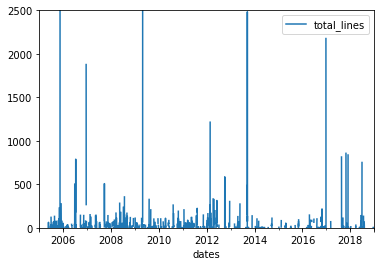

In [214]:
linus_vel.plot()
plt.ylim(0,2500)
plt.show()

We can see a pattern of velocity with significant peaks. Let's 
calculate yearly acceleration and/or speed.